In [15]:
##### imports

# For the API CAll
import requests
# Basic calculations
import numpy as np
# Stat Modelling
import statsmodels.api as sm
# JSON Handling
import json
# dataframe management
import pandas as pd
# Regular plotting
import matplotlib.pyplot as plt
# Better Visualisations
import seaborn as sns
# Basic scaling
from sklearn.preprocessing import MinMaxScaler
from sklearn import linear_model
scaler = MinMaxScaler()
#Import the required modules for test statistic calculation:
import statsmodels.stats as sm_stat
#Import the required modules for model estimation:
import statsmodels.tsa as smt
#Import the required modules for optimization:
import scipy.optimize as optimize
#We also need additional data:
import statsmodels.formula.api as smf
from matplotlib import pyplot

In [2]:
##### API CAll from KEY

def extract_api_call(sample_key):
    # Split key by "."
    key_list = sample_key.split(".")
    # Extract FlowRef
    flowRef = key_list[0]
    # Extract key 
    key = sample_key[len(key_list[0])+1:]
    # Build call string
    # API Part of URL
    api_part_generic = "https://api.statistiken.bundesbank.de/rest/data/"
    api_part_specific = flowRef+"/"+key
    api_call = api_part_generic + api_part_specific
    return api_call

In [3]:
##### Function that takes in the api-call and performs a request and stores the data in a response_json

def auto_response_saver(api_call):
    #Define the header
    headers = {'accept': 'application/vnd.sdmx.data+json;version=1.0.0',}
    # Define parameters
    params = {'detail': 'full',}
    # Define full-sub
    full_response = '?detail=full'
    # Create full call
    full_call = api_call + full_response
    # Get the actual response
    response = requests.get(full_call, params=params, headers=headers,)
    # As json
    response_list = response.json()
    return(response_list)

In [4]:
##### Take Response and return DF

def extract_response(Response, ColName):
    Response_Numbers = []
    VarKey = list(Response["data"]["dataSets"][0]["series"].keys())[0]

    for key in Response["data"]["dataSets"][0]["series"][VarKey]["observations"]:
        Response_Numbers.append(Response["data"]["dataSets"][0]["series"][VarKey]["observations"][key][0])

    Response_Numbers_PD = pd.DataFrame(Response_Numbers, columns = [ColName])    

    # General Timestamp ["data"]["structure"]["dimensions"]["observation"][0]["values"]
    Response_Timestamp = []

    for element in Response["data"]["structure"]["dimensions"]["observation"][0]["values"]:
        Response_Timestamp.append(element["id"])

    Response_Timestamp_PD = pd.DataFrame(Response_Timestamp, columns = ["time"])

    Response_DF = pd.concat([Response_Timestamp_PD,Response_Numbers_PD],axis=1).set_index("time")
    
    return Response_DF

In [5]:
##### Function, that takes in a KEY and a "Name" that then 
##### builds the api call, fetches the data, extracts the data from the response and returns dataframes separately

def BBK2PD(KEY, ColName):
    Output = extract_response(auto_response_saver(extract_api_call(KEY)), ColName)
    return Output

In [176]:
##### Function for plotting ACF and PACF for temporal correlation analysis

def plot_acf_pacf(data):
    fig = plt.figure(figsize=(12, 8))
    ax1 = fig.add_subplot(211)
    fig = sm.graphics.tsa.plot_acf(data, lags=10, ax=ax1)
    ax2 = fig.add_subplot(212)
    fig = sm.graphics.tsa.plot_pacf(data, lags=10, ax=ax2)

In [18]:
#####Variable Declaration

Keys_All = {
    
#"Gold" : "BBEX3.M.XAU.EUR.EA.AC.C06",
#"ALQ" : "BBDL1.M.DE.Y.UNE.UBA000.A0000.A01.D00.0.R00.A",
#"Zinsentwicklung" : "BBK01.SUD189",
#"Realzinssätze_Banken" : "BBK01.SUR106",
#"EZB_Einlagenfazilität" : "BBK01.SU0200",
#"HVPI" :"BBDP1.M.DE.N.HVPI.C.A00000.I15.A",
#"Effektivzinsen": "BBK01.SUD131Z",
#"Auftragseingang_Bau":"BBDY1.M.B30.Y.G800.R0400.A",    
"IR_eff_total" : "BBK01.SUD131Z",
"VOL_total" : "BBK01.SUD231",
#"IR_eff_1" : "BBK01.SUD116",
#"VOL_1" : "BBK01.SUD216",
#"IR_eff_15" : "BBK01.SUD117",
#"VOL_15" : "BBK01.SUD217",
#"IR_eff_510" : "BBK01.SUD118",
#"VOL_510" : "BBK01.SUD218",
#"IR_eff_10" : "BBK01.SUD119",
#"VOL_10" : "BBK01.SUD219"   
}

##### Create separate varables from dict

for key, value in Keys_All.items():
    exec(f"{key} = '{value}'")

In [19]:
##### Loop through the Dict and save Variables in dataframes
for key, value in Keys_All.items():
     exec(f"{key} = BBK2PD(value, key)")
        
# Create an empty list to store the values and loop through the dictionary and extract the values 
values = []
for key in Keys_All:
    values.append(globals()[key])
#Concat all variables and join the by common index.
DTF = pd.concat(values,axis=1,join="inner")
del values

In [35]:
# plot_acf_pacf(DTF_Diffed['VOL_total'])

In [36]:
# First differences
# Offset by one element since first Row will be NaN and methods wont work properly

DTF_Diffed = DTF.diff()[1:]
#DTF_Diffed.head()

In [234]:
##### Scale Features for better model performance

#scaler.fit(DTF)
#scaled_df = scaler.transform(DTF)
#scaled_df = pd.DataFrame(scaled_df, columns=DTF.columns).set_index(DTF.index)

In [37]:
#fig, axs = plt.subplots(len(DTF.columns), 1, figsize=(20, 40))

# Iterate over the columns of the dataframe
#for i, col in enumerate(DTF.columns):
  # Plot each column in a separate subplot
 # DTF[col].plot(ax=axs[i])
  # Set the title of the subplot
 # axs[i].set_title(col)

# Show the plot
#plt.show()

Nachdem die Zeitreihen Griffbereit sind und im Dataframe $\textrm{DTF}$ gespeichert ist, können nun explorative Analysen durchgeführt werden.


- Skalieren der Zeitreihen auf Werte zwischen $0$ und $1$, wie bereits in $\textrm{scaled_df}$ erstellt
- Bilden erster Differenzen $\Delta y_t = y_t - y_{t-1}$, um die Veränderung von $y_{t-1}$ auf $y_{t}$ abzubilden, sowie die Zeitreihen stationär zu machen, um ökonometrische Modelle zu schätzen. Dies ist in $\textrm{DTF_Diffed}$ umgesetzt.

In [38]:
# Correlation-Heatmap on level data, strong correlation indicate common trend, such as latent economic factors that drive the time series
# Means it is not a particularly strong indication of relationships
# sns.heatmap(DTF.corr())

In [39]:
##### Plot differenced Time Series to analyze for correlations

#fig, axs = plt.subplots(len(DTF_Diffed.columns), 1, figsize=(20, 40))

# Iterate over the columns of the dataframe
#for i, col in enumerate(DTF_Diffed.columns):
  # Plot each column in a separate subplot
 # DTF_Diffed[col].plot(ax=axs[i])
  # Set the title of the subplot
 # axs[i].set_title(col)

# Show the plot
#plt.show()

In [40]:
##### Correlations as expected

#sns.heatmap(DTF_Diffed.corr())
#print(DTF_Diffed.corr())

In [ ]:
To understand correlation structures over time one  might take cross-correlations, the following style

In [41]:
#g = sns.PairGrid(DTF, diag_sharey=False)
#g.map_upper(sns.scatterplot, s=15)
#g.map_lower(sns.kdeplot)
#g.map_diag(sns.kdeplot, lw=2)

In [42]:
#npts = len(scaled_df)
#x = np.linspace(0, 100, npts)
#y1 = scaled_df["Gold"].values
#y2 = scaled_df["Realzinssätze_Banken"].values

#lags = np.arange(-npts + 1, npts)
#ccov = np.correlate(y1 - y1.mean(), y2 - y2.mean(), mode='full')
#ccor = ccov / (npts * y1.std() * y2.std())
#
#fig, axs = plt.subplots(nrows=2)
#fig.subplots_adjust(hspace=0.4)
#ax = axs[0]
#ax.plot(x, y1, 'b', label='y1')
#ax.plot(x, y2, 'r', label='y2')
#ax.legend(loc='upper left', fontsize='small', ncol=2)

#ax = axs[1]
#ax.plot(lags, ccor)
#ax.set_ylabel('cross-correlation')
#ax.set_xlabel('lag of y1 relative to y2')

#maxlag = lags[np.argmax(ccor)]
#print("max correlation is at lag %d" % maxlag)

In [43]:
#scaled_df["ALQ"]

In [44]:
#DTF.describe()

In [45]:
#sns.regplot(x = DTF["VOL_total"], y = DTF["IR_eff_total"])

In [46]:
#sns.regplot(x = DTF["VOL_1"], y = DTF["IR_eff_1"])

In [47]:
#sns.regplot(x = DTF["VOL_10"], y = DTF["IR_eff_10"])

In [48]:
#sns.regplot(x = DTF["VOL_15"], y = DTF["IR_eff_15"])

In [49]:
#sns.regplot(x = DTF["VOL_510"], y = DTF["IR_eff_510"])

Fit an Autoregressive Distributed Lag Model to analyze temporal correlation between Interest rates and volumes and maybe some other exogenous variables.
The model of the form $$\text{Volume}_t = c + \alpha_0 \cdot \text{Volume}_{t-1} + \beta_0 \cdot \text{Interest}_{t} + \beta_1 \cdot \text{Interest}_{t-1} + \beta_2 \cdot \text{Interest}_{t-2} + \beta_3 \cdot \text{Interest}_{t-3} + \beta_4 \cdot \text{Interest}_{t-4} + \varepsilon_t  $$

Lag number of interest rates may go up to 12, to capture full year cycle dynamics


In [70]:
##### Simple function that takes a time series x and shifts it by n periods, aka lagging

def lag(x, n):
    if n == 0:
        return x
    if isinstance(x, pd.Series):
        return x.shift(n) 
    else:
        x = pd.Series(x)
        return x.shift(n) 

    x = x.copy()
    x[n:] = x[0:-n]
    x[:n] = np.nan
    return x

In [81]:
mod_L4_est = smf.ols(formula = 'DTF["VOL_total"] ~ 1 + lag(DTF["VOL_total"], 1) + lag(DTF["IR_eff_total"], 0) + lag(DTF["IR_eff_total"], 1) + lag(DTF["IR_eff_total"], 2) + lag(DTF["IR_eff_total"], 3) + lag(DTF["IR_eff_total"], 4)', data = DTF)
mod_L4_fit = mod_L4_est.fit()
print(mod_L4_fit.summary())

                            OLS Regression Results                            
Dep. Variable:       DTF["VOL_total"]   R-squared:                       0.728
Model:                            OLS   Adj. R-squared:                  0.721
Method:                 Least Squares   F-statistic:                     100.9
Date:                Tue, 03 Jan 2023   Prob (F-statistic):           4.04e-61
Time:                        12:54:06   Log-Likelihood:                -2096.1
No. Observations:                 233   AIC:                             4206.
Df Residuals:                     226   BIC:                             4230.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept         

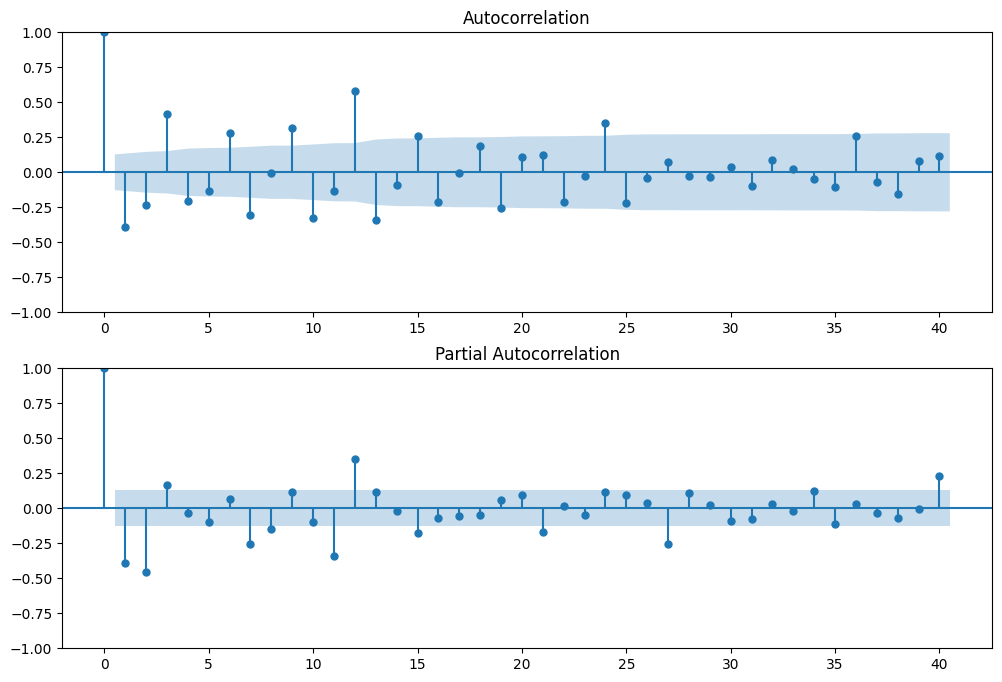

In [84]:
plot_acf_pacf(DTF_Diffed["VOL_total"])

In [109]:
mod_L12_est = smf.ols(formula = 'DTF["VOL_total"] ~ 1 + lag(DTF["IR_eff_total"], 0) + lag(DTF["IR_eff_total"], 1) + lag(DTF["IR_eff_total"], 2) + lag(DTF["IR_eff_total"], 3) + lag(DTF["IR_eff_total"], 4) + lag(DTF["IR_eff_total"], 5) + lag(DTF["IR_eff_total"], 6) + lag(DTF["IR_eff_total"], 7) + lag(DTF["IR_eff_total"], 8) + lag(DTF["IR_eff_total"], 9) + lag(DTF["IR_eff_total"], 10) + lag(DTF["IR_eff_total"], 11) + lag(DTF["IR_eff_total"], 12) ', data = DTF)
mod_L12_fit = mod_L12_est.fit()
print(mod_L12_fit.summary())

                            OLS Regression Results                            
Dep. Variable:       DTF["VOL_total"]   R-squared:                       0.681
Model:                            OLS   Adj. R-squared:                  0.661
Method:                 Least Squares   F-statistic:                     34.61
Date:                Tue, 03 Jan 2023   Prob (F-statistic):           3.33e-45
Time:                        14:59:14   Log-Likelihood:                -2042.5
No. Observations:                 225   AIC:                             4113.
Df Residuals:                     211   BIC:                             4161.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept       

In [79]:
DTF["VOL_total"].describe()

count      237.000000
mean     17656.599156
std       3748.882611
min       9950.000000
25%      14935.000000
50%      16761.000000
75%      20235.000000
max      32270.000000
Name: VOL_total, dtype: float64

<AxesSubplot: >

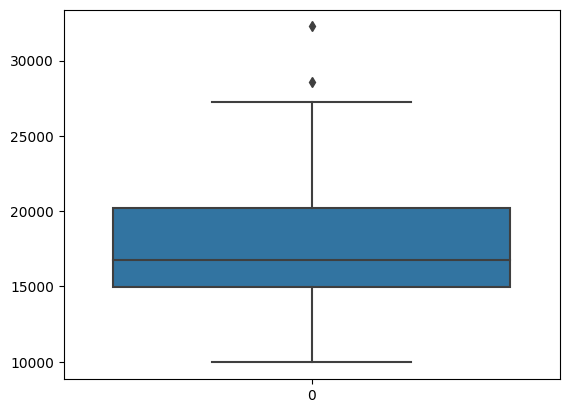

In [80]:
sns.boxplot(DTF["VOL_total"])

In [106]:
import pmdarima as pm

stepwise_fit = pm.auto_arima(DTF_Diffed["VOL_total"], start_p=1, start_q=1,
                             max_p=12, max_q=12, m=12,
                             start_P=0, seasonal=True,
                             d=1, D=1, trace=True,
                             error_action='ignore',  # don't want to know if an order does not work
                             suppress_warnings=True,  # don't want convergence warnings
                             stepwise=False)  # set to stepwise

 ARIMA(0,1,0)(0,1,0)[12]             : AIC=4271.235, Time=0.03 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=4228.871, Time=0.24 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=inf, Time=0.78 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=4265.739, Time=0.09 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=inf, Time=0.40 sec
 ARIMA(0,1,0)(1,1,2)[12]             : AIC=inf, Time=1.10 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=4254.739, Time=0.31 sec
 ARIMA(0,1,0)(2,1,1)[12]             : AIC=4197.595, Time=1.38 sec
 ARIMA(0,1,0)(2,1,2)[12]             : AIC=4173.960, Time=1.62 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=inf, Time=0.10 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.37 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=inf, Time=1.10 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=inf, Time=0.35 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=inf, Time=0.53 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=inf, Time=2.22 sec
 ARIMA(0,1,1)(2,1,0)[12]             : A

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=5364.293, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=4614.521, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=4360.595, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=4336.488, Time=0.05 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=4293.708, Time=0.06 sec
 ARIMA(4,0,0)(0,0,0)[0] intercept   : AIC=4285.858, Time=0.11 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=4287.841, Time=0.14 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=inf, Time=0.09 sec

Best model:  ARIMA(4,0,0)(0,0,0)[0] intercept
Total fit time: 0.525 seconds


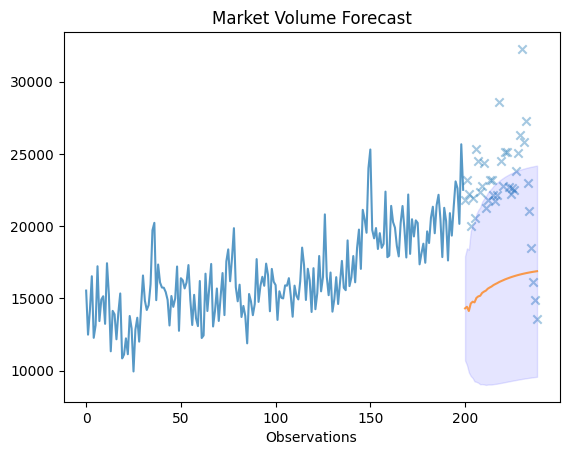

In [140]:
import pmdarima as pm
from pmdarima.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

y = DTF["VOL_total"]
train, test = train_test_split(y, train_size=200)

# Fit model
model = pm.auto_arima(DTF["VOL_total"], start_p=0, start_q=0,
                             max_p=12, max_q=0, m=0,
                             start_P=1, seasonal=False,
                             d=0, D=0, trace=True,
                             error_action='ignore',  # don't want to know if an order does not work
                             suppress_warnings=True,  # don't want convergence warnings
                             stepwise=True)  # set to stepwise

# make forecasts

preds, conf_int = model.predict(n_periods=test.shape[0], return_conf_int=True)

# #############################################################################
# Plot the points and the forecasts
x_axis = np.arange(train.shape[0] + preds.shape[0])
x_years = x_axis  

plt.plot(x_years[x_axis[:train.shape[0]]], train, alpha=0.75)
plt.plot(x_years[x_axis[train.shape[0]:]], preds, alpha=0.75)  # Forecasts
plt.scatter(x_years[x_axis[train.shape[0]:]], test,
            alpha=0.4, marker='x')  # Test data
plt.fill_between(x_years[x_axis[-preds.shape[0]:]],
                 conf_int[:, 0], conf_int[:, 1],
                 alpha=0.1, color='b')
plt.title("Market Volume Forecast")
plt.xlabel("Observations")

# Visualize the forecasts (blue=train, green=forecasts)
#x = np.arange(y.shape[0])
#plt.plot(x[:220], train, c='blue')
#plt.plot(x[220:], forecasts, c='green')
plt.show()

In [11]:
def plot_tsresiduals(Y, y, acf_lags=np.r_[1:26]):
    """Plot timeseries residuals for ground truth Y and estimate y."""
    fig = plt.figure()
    gs = plt.GridSpec(3, 2, figure=fig)
    ts_ax = fig.add_subplot(gs[0,:])
    axs = np.array([ts_ax] + [fig.add_subplot(gs[i,j]) for j in (0,1) for i in (1,2)])
    ax, rax, hax, acfax, pacfax = axs
    #((ax, hax), (rax, acfax)) = axs
    mask = ~(np.isnan(Y) | np.isnan(y))
    Y, y = Y[mask], y[mask]
    #dy = y - Y
    # I was surprised by this convention but ok
    dy = Y - y
    ax.plot(Y, color='k')
    ax.plot(y)
    ax.set(title='Time Series')
    lim = 1.1 * max(-dy.min(), dy.max())
    lim = -lim, lim
    rax.plot(dy)
    rax.set(ylim=lim, title='Residuals')
    sns.distplot(dy, bins=np.linspace(lim[0], lim[1], 22),
                 hist=True, kde=True, rug=True, ax=hax)
    hax.set(title='Residual Distribution')
    sm.graphics.tsa.plot_acf(dy, lags=acf_lags, ax=acfax)
    sm.graphics.tsa.plot_pacf(dy, lags=acf_lags, ax=pacfax)
    for a in axs.ravel():
        a.grid()
    plt.tight_layout()
    return fig, axs

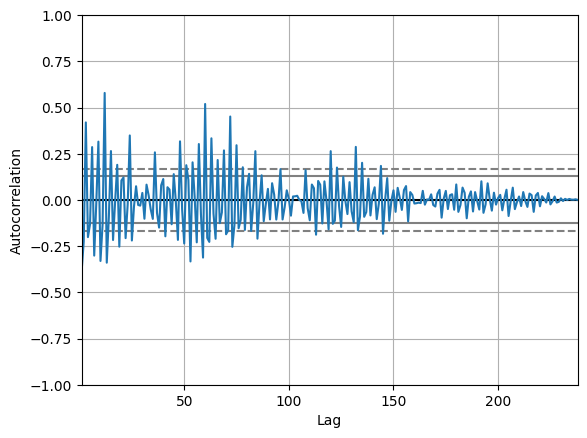

In [28]:
from pandas import read_csv
from pandas import DataFrame
from pandas import Grouper
from pandas.plotting import autocorrelation_plot
from matplotlib import pyplot
series = DTF_Diffed['VOL_total']
autocorrelation_plot(series)
pyplot.show()

<AxesSubplot: xlabel='time', ylabel='VOL_total'>

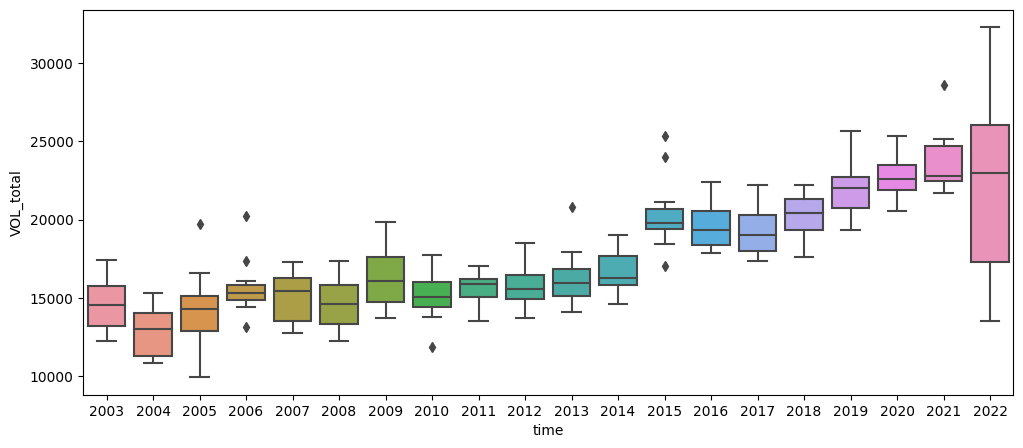

In [73]:
fig, ax = plt.subplots(figsize=(12,5))
sns.boxplot(x = DTF.index.year,
                y = DTF['VOL_total'], 
                ax = ax)

time
2003-01-01        NaN
2003-02-01        NaN
2003-03-01        NaN
2003-04-01        NaN
2003-05-01    14214.8
2003-06-01    13735.2
2003-07-01    14681.8
2003-08-01    14527.2
2003-09-01    14204.4
2003-10-01    14779.8
Name: VOL_total, dtype: float64


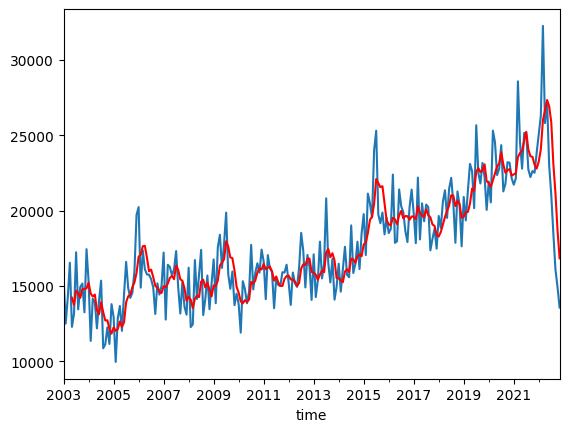

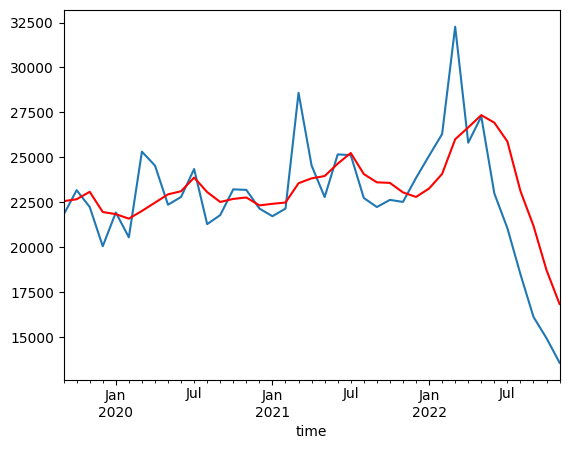

In [120]:
# tail-rolling average transform
rolling = DTF['VOL_total'].rolling(window=5)
rolling_mean = rolling.mean()
print(rolling_mean.head(10))
# plot original and transformed dataset
series.plot()
rolling_mean.plot(color='red')
pyplot.show()

# zoomed plot original and transformed dataset
DTF['VOL_total'][200:].plot()
rolling_mean[200:].plot(color='red')
pyplot.show()

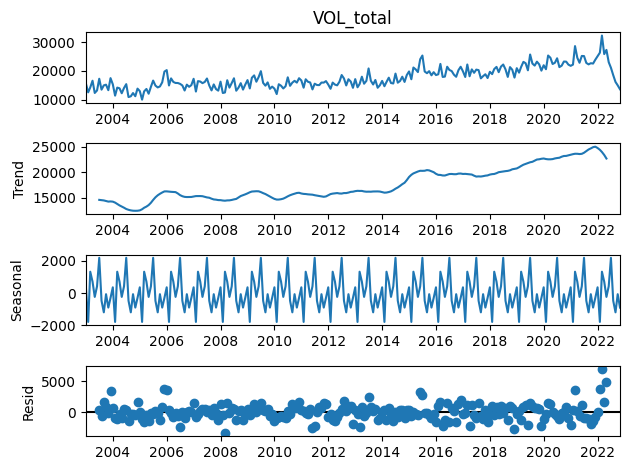

In [86]:
from statsmodels.tsa.seasonal import seasonal_decompose
series = DTF['VOL_total']
result = seasonal_decompose(series, model='additive')
result.plot()
pyplot.show()

<bound method NDFrame.head of time
2003-01-01     356.587557
2003-02-01   -1802.669022
2003-03-01    1329.591943
2003-04-01     707.598522
2003-05-01    -242.017706
                 ...     
2022-07-01    2196.905539
2022-08-01    -480.065952
2022-09-01   -1203.041829
2022-10-01     -72.298408
2022-11-01    -908.565952
Name: seasonal, Length: 239, dtype: float64>

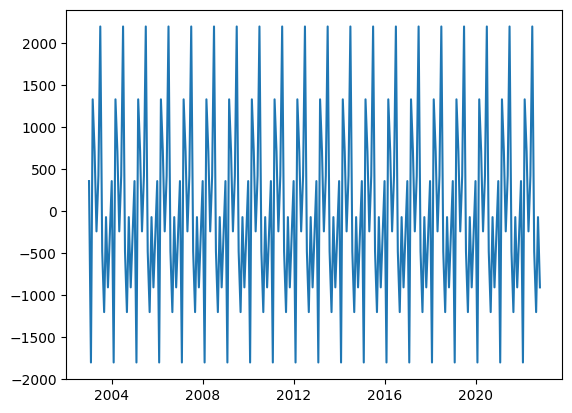

In [146]:
plt.plot(result.seasonal)
result.seasonal.head

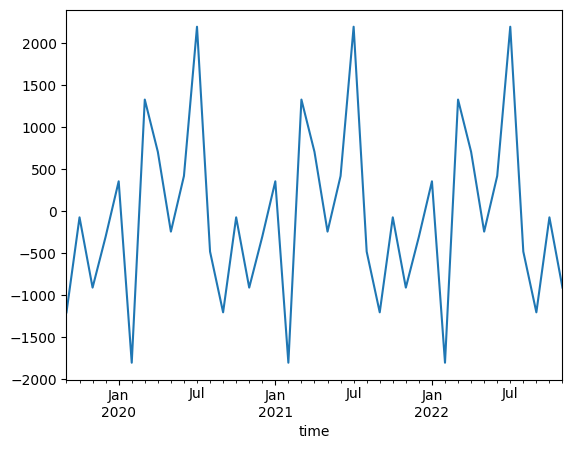

In [147]:
# zoomed plot original and transformed dataset
result.seasonal[200:].plot()
pyplot.show()


<AxesSubplot: xlabel='time', ylabel='seasonal'>

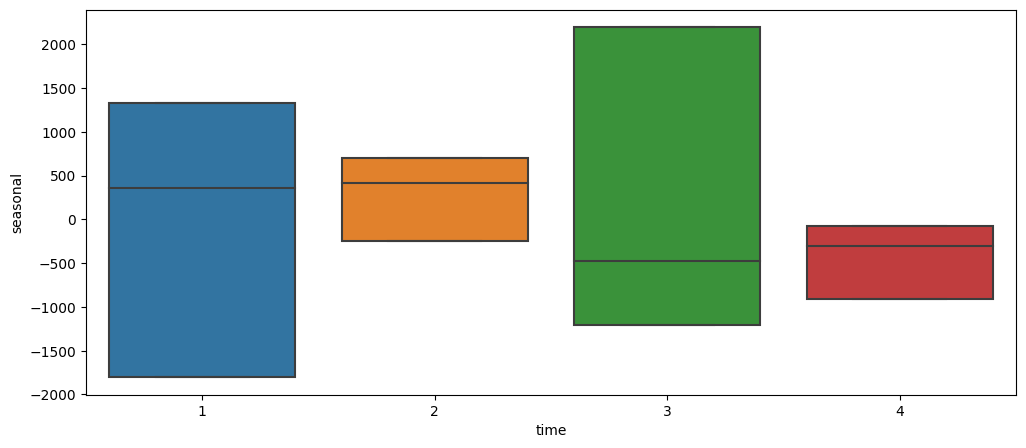

In [88]:
fig, ax = plt.subplots(figsize=(12,5))
sns.boxplot(x = DTF.index.quarter,
                y = result.seasonal, 
                ax = ax)

In [151]:
Prov_df = pd.read_excel("P&L_Hist.xlsx")
Prov_df.index = pd.date_range(start='2020-01-01', end='2022-12-31', freq='M')
Prov_df.index

DatetimeIndex(['2020-01-31', '2020-02-29', '2020-03-31', '2020-04-30',
               '2020-05-31', '2020-06-30', '2020-07-31', '2020-08-31',
               '2020-09-30', '2020-10-31', '2020-11-30', '2020-12-31',
               '2021-01-31', '2021-02-28', '2021-03-31', '2021-04-30',
               '2021-05-31', '2021-06-30', '2021-07-31', '2021-08-31',
               '2021-09-30', '2021-10-31', '2021-11-30', '2021-12-31',
               '2022-01-31', '2022-02-28', '2022-03-31', '2022-04-30',
               '2022-05-31', '2022-06-30', '2022-07-31', '2022-08-31',
               '2022-09-30', '2022-10-31', '2022-11-30', '2022-12-31'],
              dtype='datetime64[ns]', freq='M')

<AxesSubplot: ylabel='seasonal'>

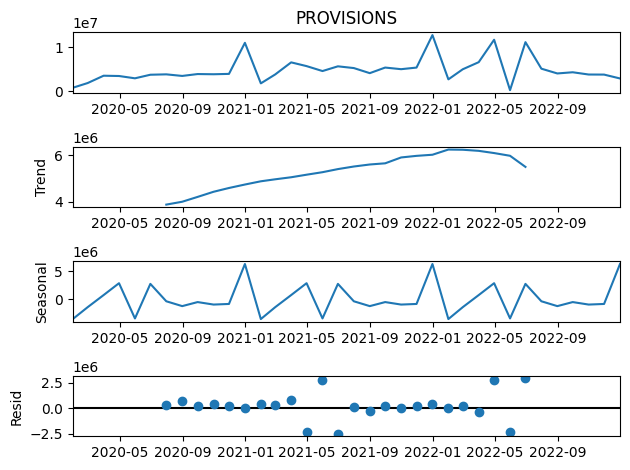

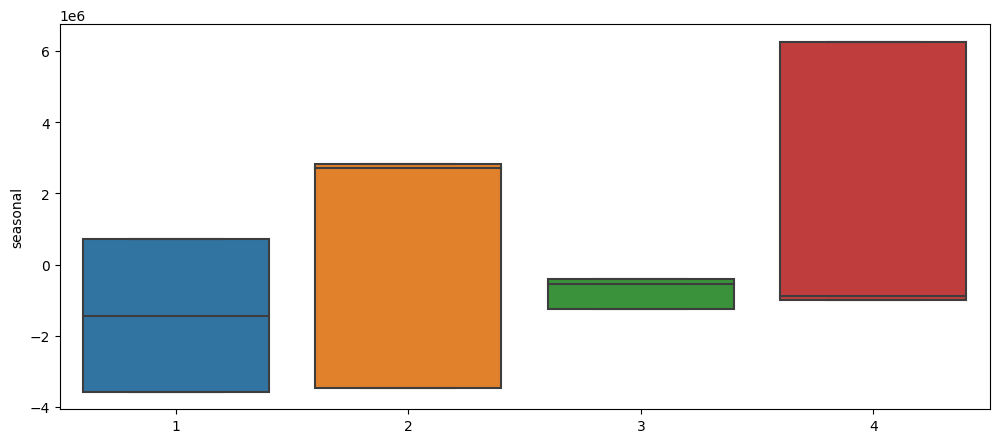

In [154]:
series_prov = Prov_df['PROVISIONS']
result_prov = seasonal_decompose(series_prov, model='additive')
result_prov.plot()

fig, ax = plt.subplots(figsize=(12,5))
sns.boxplot(x = Prov_df.index.quarter,
                y = result_prov.seasonal, 
                ax = ax)

In [173]:
DTF.index = pd.date_range(start='2003-01-01', end='2022-12-01', freq='M')
Comp = pd.concat([Prov_df['PROVISIONS'],DTF['VOL_total']],axis=1,join="inner")
Comp.describe()

,PROVISIONS,VOL_total
count,3.500000e+01,35.000000
mean,4.847093e+06,22895.657143
std,2.847765e+06,3523.421315
min,2.059400e+05,13564.000000
25%,3.602747e+06,21854.500000
50%,4.006230e+06,22786.000000
75%,5.345654e+06,24813.000000
max,1.273766e+07,32270.000000


C:\Users\JulianHilgemann(Bilt\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



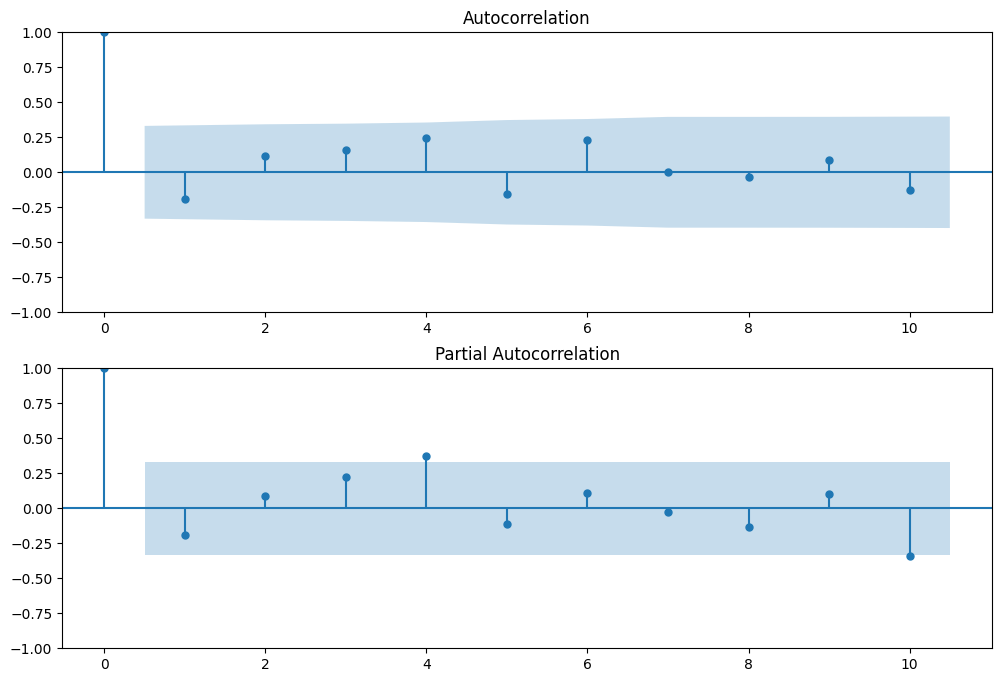

In [177]:
plot_acf_pacf(Comp['PROVISIONS'])

In [178]:
Comp['PROVISIONS'].corr(Comp['VOL_total'])

0.1945790957117342

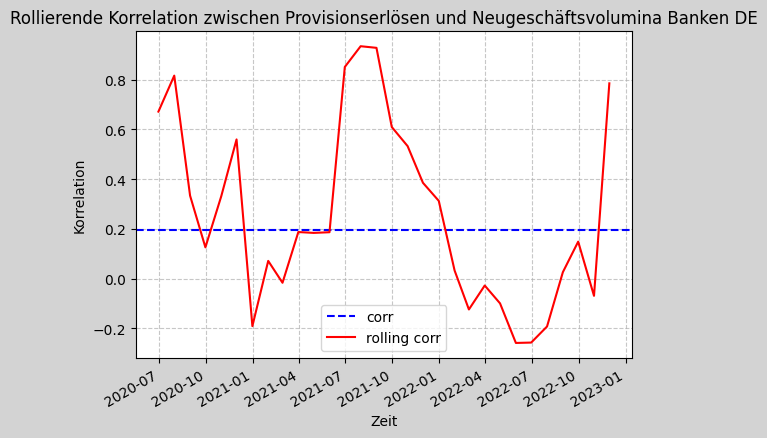

In [205]:
%matplotlib inline

rolling_correlation = Comp['PROVISIONS'].rolling(window=6).corr(Comp['VOL_total'])
fig, ax = plt.subplots()
fig.set_facecolor('lightgray')
ax.axhline(y=Comp['PROVISIONS'].corr(Comp['VOL_total']), color='blue', linestyle='--', label = "corr")
rolling_correlation.plot(color='red',label="rolling corr")
ax.grid(True, linestyle='--', alpha=0.7)
ax.set_title('Rollierende Korrelation zwischen Provisionserlösen und Neugeschäftsvolumina Banken DE')
ax.set_xlabel('Zeit')
ax.set_ylabel('Korrelation')
ax.legend()
pyplot.show()

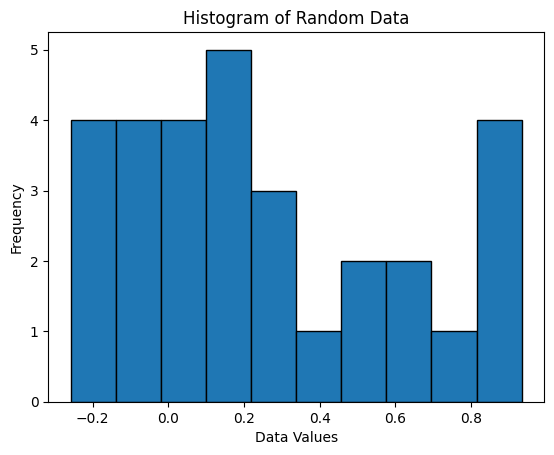

In [219]:
fig, ax = plt.subplots()
ax.hist(rolling_correlation, bins=10, edgecolor='black')
ax.set_title('Histogram of Random Data')
ax.set_xlabel('Data Values')
ax.set_ylabel('Frequency')
pyplot.show()

In [236]:
import numpy as np
import random

x = Comp['PROVISIONS']
print(np.mean(x))

sample_mean = []
for i in range(200000):
  y = random.sample(x.tolist(), 4)
  avg = np.mean(y)
  sample_mean.append(avg)

print(np.mean(sample_mean))

4847093.001428571
4843912.619159388


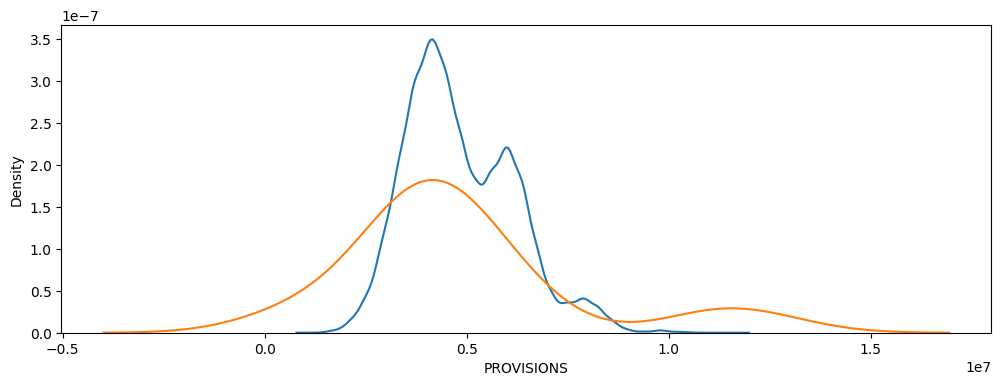

In [237]:
fig, axs = plt.subplots(1, 1, figsize=(12, 4))
sns.kdeplot(sample_mean)
sns.kdeplot(Comp['PROVISIONS'])

# Show the plot
plt.show()

4847093.001428571
4841753.912749074


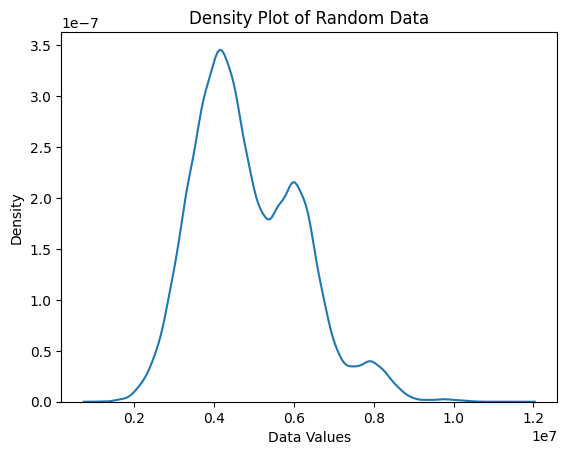

In [225]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
sns.kdeplot(df1['col1'], ax=axs[0])
sns.kdeplot(df2['col2'], ax=axs[1])

# Label each plot
axs[0].set_title('KDE of col1')
axs[1].set_title('KDE of col2')

# Show the plot
plt.show()